In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as mn

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer

from sklearn import set_config
set_config(display='diagram')

#Nate shared this list as his ultimate go-to during our regresssion hack-a-thon

In [2]:
df_ames_train = pd.read_csv('./datasets/train.csv')

In [3]:
print(list(df_ames_train))
#found how to get a list of all columns name in my dataframe from datatofish.com

['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Wood Deck SF'

In [4]:
df_ames_train['Sale Type'].value_counts()

#Decided not to use this variable looking at this distribution

WD       1781
New       160
COD        63
ConLD      17
CWD        10
ConLI       7
ConLw       5
Con         4
Oth         4
Name: Sale Type, dtype: int64

In [5]:
df_ames_train['Overall Qual'].value_counts(dropna=False)
#Yes, use, but need to treat as a categorical variable

5     563
6     506
7     431
8     250
4     159
9      77
3      29
10     23
2       9
1       4
Name: Overall Qual, dtype: int64

In [6]:
df_ames_train['Garage Cars'].value_counts(dropna=False)
#Yes, use

2.0    1136
1.0     524
3.0     263
0.0     113
4.0      13
5.0       1
NaN       1
Name: Garage Cars, dtype: int64

In [7]:
df_ames_train['Full Bath'].value_counts(dropna=False)
#yes, use

2    1096
1     900
3      45
0       8
4       2
Name: Full Bath, dtype: int64

In [8]:
df_ames_train['TotRms AbvGrd'].value_counts(dropna=False)
#yes, use

6     597
7     475
5     407
8     228
4     146
9      98
10     49
11     22
12     13
3      12
14      1
2       1
13      1
15      1
Name: TotRms AbvGrd, dtype: int64

In [9]:
df_ames_train['Fireplaces'].value_counts(dropna=False)
#yes, use

0    1000
1     898
2     146
3       6
4       1
Name: Fireplaces, dtype: int64

In [10]:
df_ames_train['Neighborhood'].value_counts(dropna=False)
#yes, use, categorical

NAmes      310
CollgCr    180
OldTown    163
Edwards    143
Somerst    130
NridgHt    122
Gilbert    116
Sawyer     111
NWAmes      87
SawyerW     87
Mitchel     82
BrkSide     76
Crawfor     71
IDOTRR      69
NoRidge     48
Timber      48
StoneBr     38
SWISU       32
ClearCr     27
MeadowV     24
Blmngtn     22
BrDale      19
Veenker     17
NPkVill     17
Blueste      6
Greens       3
GrnHill      2
Landmrk      1
Name: Neighborhood, dtype: int64

In [11]:
df_ames_train['Neighborhood'].isna().sum()

0

In [12]:
df_ames_train[['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars',
'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Year Remod/Add', 'Full Bath', 'Garage Yr Blt',
'Mas Vnr Area', 'TotRms AbvGrd', 'Fireplaces', 'BsmtFin SF 1', 'Lot Frontage',
'Open Porch SF', 'Wood Deck SF', 'Lot Area', 'SalePrice']]

,Overall Qual,Gr Liv Area,Garage Area,Garage Cars,Total Bsmt SF,1st Flr SF,Year Built,Year Remod/Add,Full Bath,Garage Yr Blt,Mas Vnr Area,TotRms AbvGrd,Fireplaces,BsmtFin SF 1,Lot Frontage,Open Porch SF,Wood Deck SF,Lot Area,SalePrice
0,6,1479,475.0,2.0,725.0,725,1976,2005,2,1976.0,289.0,6,0,533.0,NaN,44,0,13517,130500
1,7,2122,559.0,2.0,913.0,913,1996,1997,2,1997.0,132.0,8,1,637.0,43.0,74,0,11492,220000
2,5,1057,246.0,1.0,1057.0,1057,1953,2007,1,1953.0,0.0,5,0,731.0,68.0,52,0,7922,109000
3,5,1444,400.0,2.0,384.0,744,2006,2007,2,2007.0,0.0,7,0,0.0,73.0,0,100,9802,174000
4,6,1445,484.0,2.0,676.0,831,1900,1993,2,1957.0,0.0,6,0,0.0,82.0,59,0,14235,138500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,8,1728,520.0,2.0,1884.0,1728,2007,2007,2,2007.0,0.0,7,1,1011.0,79.0,276,0,11449,298751
2047,4,861,539.0,2.0,861.0,861,1940,1950,1,1961.0,0.0,4,0,262.0,NaN,0,158,12342,82500
2048,6,1913,342.0,2.0,896.0,1172,1928,1950,1,1929.0,0.0,9,1,0.0,57.0,0,0,7558,177000
2049,4,1200,294.0,1.0,1200.0,1200,1956,1956,1,1956.0,0.0,6,2,155.0,80.0,189,0,10400,144000


In [13]:
df_ames_tr_1st5 =df_ames_train[['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars',
'Total Bsmt SF', 'SalePrice']]
df_ames_tr_2nd5 =df_ames_train[['1st Flr SF', 'Year Built', 'Year Remod/Add', 'Full Bath', 'Garage Yr Blt', 'SalePrice']]
df_ames_tr_3rd5 =df_ames_train[['Mas Vnr Area', 'TotRms AbvGrd', 'Fireplaces', 'BsmtFin SF 1', 'Lot Frontage', 'SalePrice']]
df_ames_tr_4th5 =df_ames_train[['Open Porch SF', 'Wood Deck SF', 'Lot Area', 'SalePrice']]

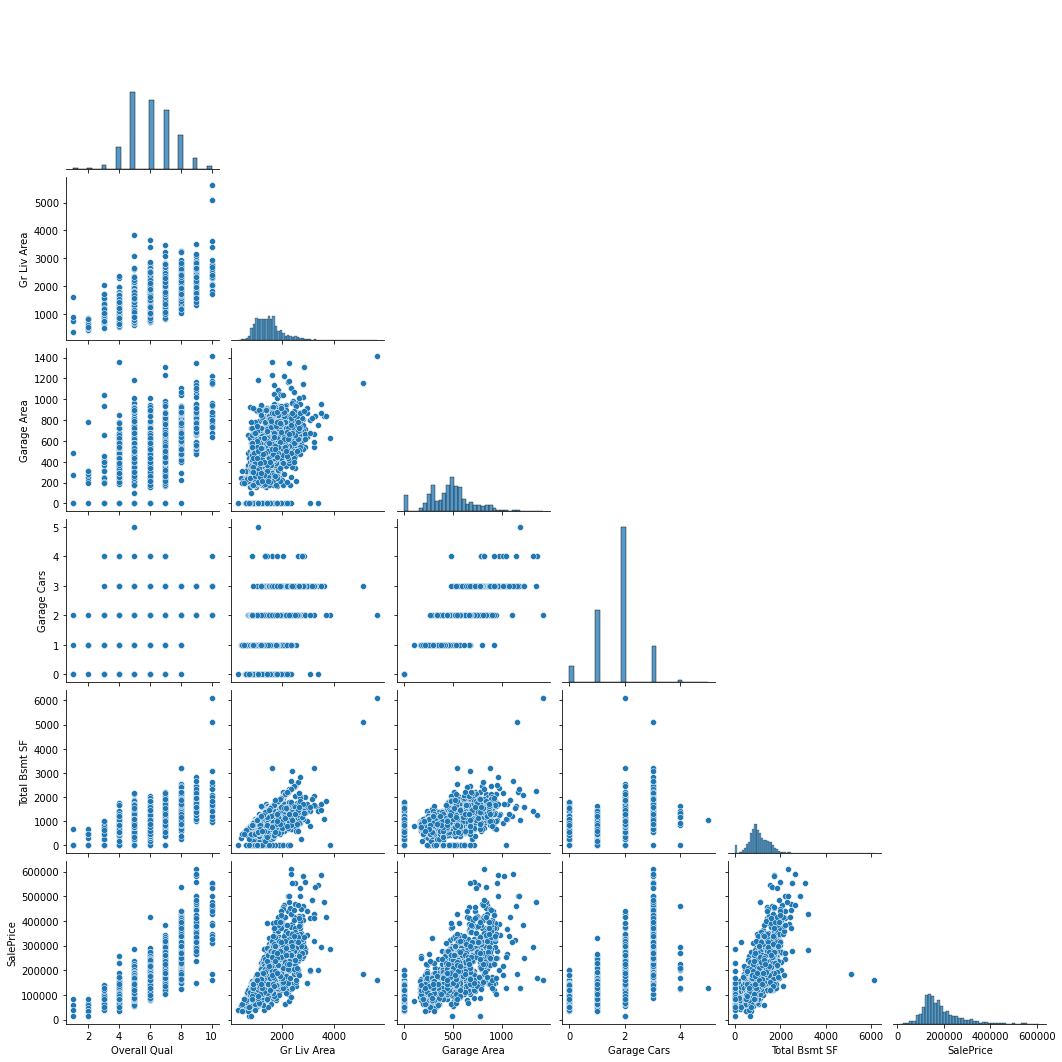

In [14]:
sns.pairplot(df_ames_tr_1st5, corner=True);

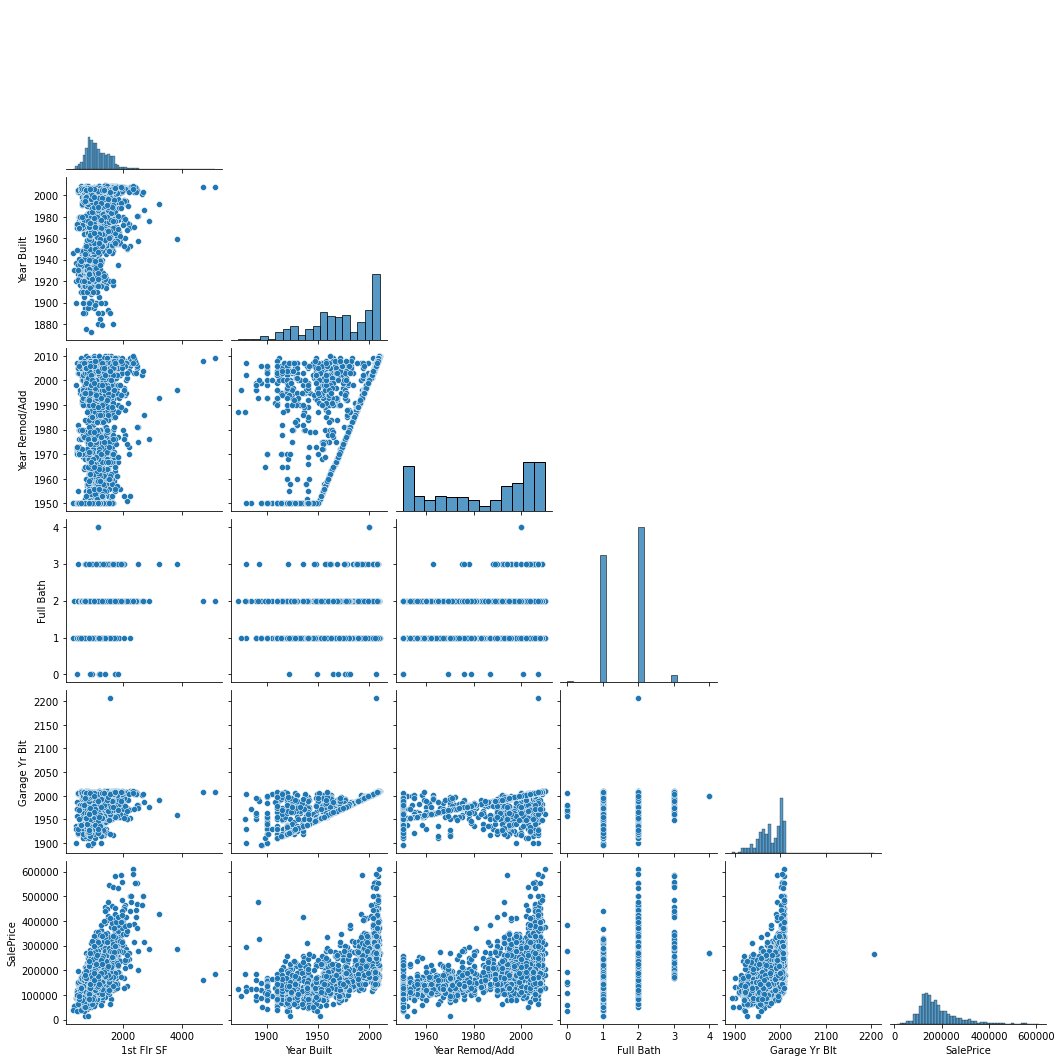

In [15]:
sns.pairplot(df_ames_tr_2nd5, corner=True);

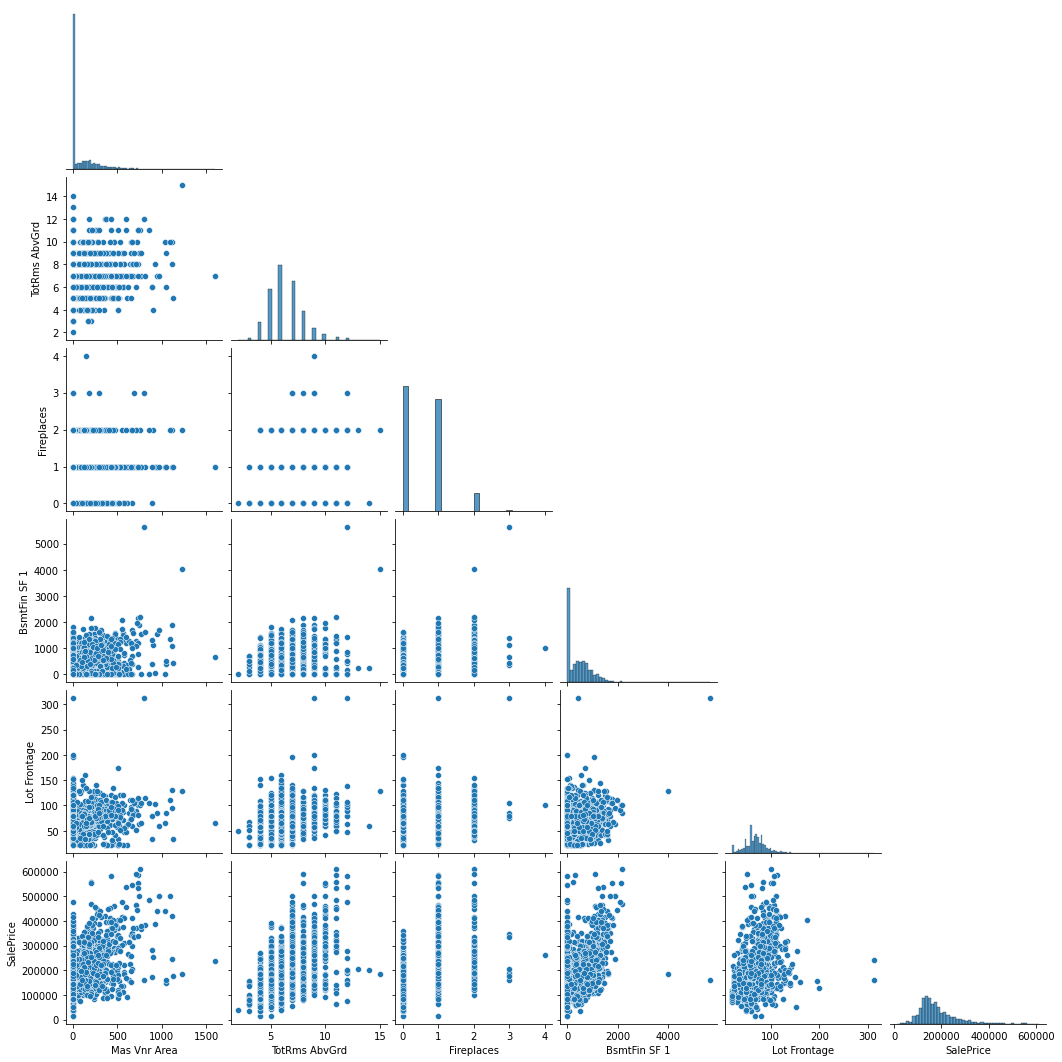

In [16]:
sns.pairplot(df_ames_tr_3rd5, corner=True);

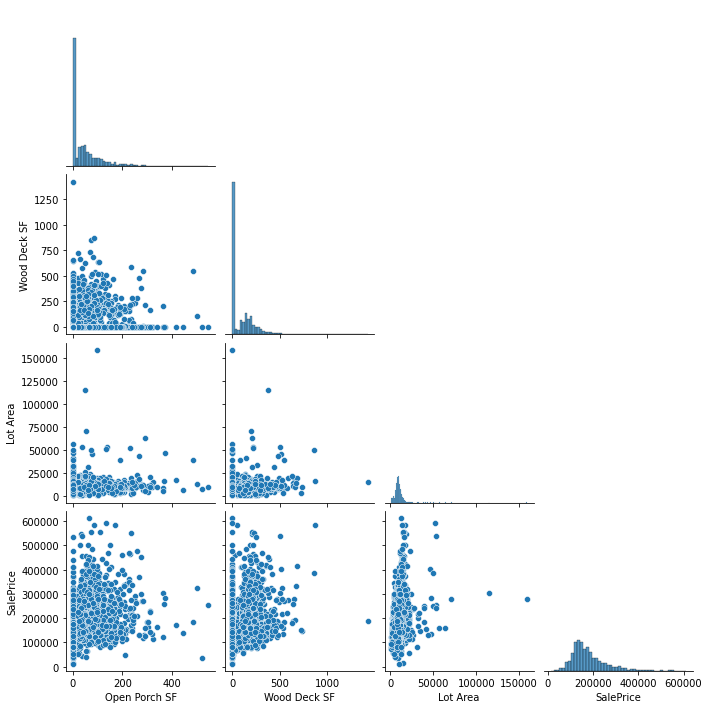

In [17]:
sns.pairplot(df_ames_tr_4th5, corner=True);

I know I need to split my data into train/test before I do any data transformations and build any models.

In [18]:
df_ames_sub_train = df_ames_train[['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars',
'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Year Remod/Add', 'Full Bath', 'Garage Yr Blt',
'Mas Vnr Area', 'TotRms AbvGrd', 'Fireplaces', 'BsmtFin SF 1', 'Lot Frontage',
'Open Porch SF', 'Wood Deck SF', 'Lot Area', 'SalePrice']]

In [19]:
#Check for missing data
df_ames_sub_train.isna().sum()

Overall Qual        0
Gr Liv Area         0
Garage Area         1
Garage Cars         1
Total Bsmt SF       1
1st Flr SF          0
Year Built          0
Year Remod/Add      0
Full Bath           0
Garage Yr Blt     114
Mas Vnr Area       22
TotRms AbvGrd       0
Fireplaces          0
BsmtFin SF 1        1
Lot Frontage      330
Open Porch SF       0
Wood Deck SF        0
Lot Area            0
SalePrice           0
dtype: int64

For my first Lasso model, I will not use data that has missing values in my X matrix.  Therefore, I will not use Garage Year Built, Mas Vnr Area or Lot Frontage since they have 22 or more missing values.  I will then drop any rows with missing values for Garage Cars, Total Basement SF, and BsmtFin SF 1.  They each only have one value missing, that would be a max of 3 records dropped and I am okay with that.  Also, I would like to use two categorical variable, Overall Quality and Neighborhood, but to keep things simple I will not use them.  

In [20]:
df_ames_las_train = df_ames_train[['Gr Liv Area', 'Garage Cars',
'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Year Remod/Add', 'Full Bath',
'TotRms AbvGrd', 'Fireplaces', 'BsmtFin SF 1',
'Open Porch SF', 'Wood Deck SF', 'Lot Area', 'SalePrice']]

In [21]:
df_ames_las_train.isna().sum()

Gr Liv Area       0
Garage Cars       1
Total Bsmt SF     1
1st Flr SF        0
Year Built        0
Year Remod/Add    0
Full Bath         0
TotRms AbvGrd     0
Fireplaces        0
BsmtFin SF 1      1
Open Porch SF     0
Wood Deck SF      0
Lot Area          0
SalePrice         0
dtype: int64

In [22]:
#I am totally okay with dropping the rows with missing data
df_ames_las_train.dropna(inplace=True)

C:\Users\sarah\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [23]:
df_ames_las_train.isna().sum()

Gr Liv Area       0
Garage Cars       0
Total Bsmt SF     0
1st Flr SF        0
Year Built        0
Year Remod/Add    0
Full Bath         0
TotRms AbvGrd     0
Fireplaces        0
BsmtFin SF 1      0
Open Porch SF     0
Wood Deck SF      0
Lot Area          0
SalePrice         0
dtype: int64

In [24]:

X = df_ames_las_train[['Gr Liv Area', 'Garage Cars',
'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Year Remod/Add', 'Full Bath',
'TotRms AbvGrd', 'Fireplaces', 'BsmtFin SF 1',
'Open Porch SF', 'Wood Deck SF', 'Lot Area']]
y = df_ames_las_train['SalePrice']
    

In [25]:
X.shape

(2049, 13)

In [26]:
y.shape

(2049,)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [28]:
pipe1 = make_pipeline(StandardScaler(), Lasso())
pipe1

Pipeline(steps=[('standardscaler', StandardScaler()), ('lasso', Lasso())])

In [29]:
params1 = {'lasso__alpha':[.01,.1,1,10,100]} 
params1

{'lasso__alpha': [0.01, 0.1, 1, 10, 100]}

In [30]:
gs1 = GridSearchCV(pipe1, params1, n_jobs=1) 
gs1

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             n_jobs=1, param_grid={'lasso__alpha': [0.01, 0.1, 1, 10, 100]})

In [31]:
gs1.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             n_jobs=1, param_grid={'lasso__alpha': [0.01, 0.1, 1, 10, 100]})

In [32]:
gs1.best_params_

{'lasso__alpha': 100}

In [33]:
pd.DataFrame(gs1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lasso__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004802,0.002135,0.001401,0.000492,0.01,{'lasso__alpha': 0.01},0.820563,0.794613,0.579817,0.813225,0.795930,0.760830,0.091052,5
1,0.004000,0.001545,0.001403,0.000495,0.1,{'lasso__alpha': 0.1},0.820563,0.794612,0.579818,0.813226,0.795930,0.760830,0.091051,4
2,0.003403,0.000489,0.001799,0.000980,1,{'lasso__alpha': 1},0.820561,0.794609,0.579831,0.813229,0.795932,0.760833,0.091046,3
3,0.003199,0.000393,0.001398,0.000487,10,{'lasso__alpha': 10},0.820546,0.794572,0.579957,0.813263,0.795957,0.760859,0.090998,2
4,0.003404,0.000797,0.001601,0.000490,100,{'lasso__alpha': 100},0.820281,0.794186,0.581183,0.813583,0.796148,0.761076,0.090499,1


In [34]:
gs1.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=100))])

In [35]:
gs1.best_estimator_.named_steps

{'standardscaler': StandardScaler(), 'lasso': Lasso(alpha=100)}

In [36]:
gs1.best_estimator_.named_steps['standardscaler'].get_feature_names_out()

array(['Gr Liv Area', 'Garage Cars', 'Total Bsmt SF', '1st Flr SF',
       'Year Built', 'Year Remod/Add', 'Full Bath', 'TotRms AbvGrd',
       'Fireplaces', 'BsmtFin SF 1', 'Open Porch SF', 'Wood Deck SF',
       'Lot Area'], dtype=object)

In [37]:
gs1.best_estimator_.named_steps['lasso'].coef_

array([32970.38713529, 11335.71291305, 14335.52150992,   221.67717332,
       13206.26006092, 13526.25490018, -2727.85837192, -2830.71917023,
        7563.66120551,  9142.14505807,  1281.70248369,  1813.30373261,
        2765.36443109])

In [38]:
X_train.columns

Index(['Gr Liv Area', 'Garage Cars', 'Total Bsmt SF', '1st Flr SF',
       'Year Built', 'Year Remod/Add', 'Full Bath', 'TotRms AbvGrd',
       'Fireplaces', 'BsmtFin SF 1', 'Open Porch SF', 'Wood Deck SF',
       'Lot Area'],
      dtype='object')

In [39]:
pd.DataFrame(zip(X_train.columns, gs1.best_estimator_.named_steps['lasso'].coef_))

,0,1
0,Gr Liv Area,32970.387135
1,Garage Cars,11335.712913
2,Total Bsmt SF,14335.521510
3,1st Flr SF,221.677173
4,Year Built,13206.260061
5,Year Remod/Add,13526.254900
6,Full Bath,-2727.858372
7,TotRms AbvGrd,-2830.719170
8,Fireplaces,7563.661206
9,BsmtFin SF 1,9142.145058


In [40]:
gs1.best_estimator_.named_steps['lasso'].intercept_

180680.44661458337

In [41]:
gs1.score(X_test, y_test)

0.6696789349090324

In [42]:
#Make predictions on the test set
preds = gs1.predict(X_test)

In [43]:
#Evaluate my metrics
print('Lasso Model #1: MAE:', mean_absolute_error(y_test, preds))
print('Lasso Model #1: MSE:', mean_squared_error(y_test, preds))
print('Lasso Model #1: R2:', r2_score(y_test, preds))

Lasso Model #1: MAE: 26255.439545100216
Lasso Model #1: MSE: 2158173486.1942644
Lasso Model #1: R2: 0.6696789349090324


This model beats both the previous linear regression model and the baseline model.  The Rsquared here is .7186 compared to -.0037 for the baseline model and .5667 for the linear regression model.

In [44]:
#I want to look at some graphs of my residuals
residuals = preds - y_test

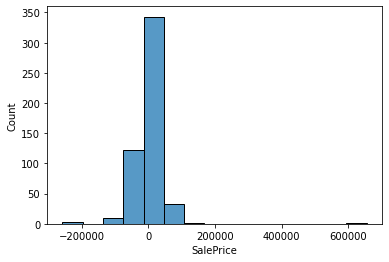

In [45]:
sns.histplot(residuals, bins=15);
#This looks like a normal distribution so this doesn't look too bad.

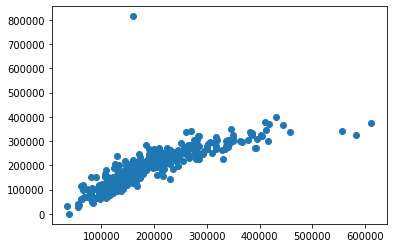

In [46]:
plt.scatter(y_test, preds);
#This doesn't look too bad!

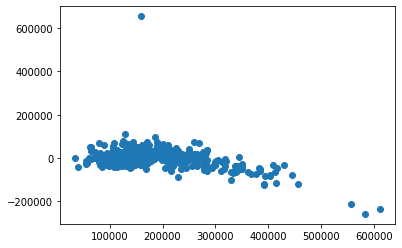

In [47]:
plt.scatter(y_test, residuals);
#That outlier at 200,000 is strange.

In [48]:
#Now, I want to use my Lasso model to score the separate test dataset so 
# that I can submit a csv file to Kaggle for the contest.

df_ames_test = pd.read_csv('./datasets/test.csv')

In [49]:
df_ames_test.head(2)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD


In [50]:
#Pull off only the data I need
df_mini_las_test = df_ames_test[['Gr Liv Area', 'Garage Cars',
'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Year Remod/Add', 'Full Bath',
'TotRms AbvGrd', 'Fireplaces', 'BsmtFin SF 1',
'Open Porch SF', 'Wood Deck SF', 'Lot Area']]

In [51]:
#Yay!  No missing data here!
df_mini_las_test.isna().sum()

Gr Liv Area       0
Garage Cars       0
Total Bsmt SF     0
1st Flr SF        0
Year Built        0
Year Remod/Add    0
Full Bath         0
TotRms AbvGrd     0
Fireplaces        0
BsmtFin SF 1      0
Open Porch SF     0
Wood Deck SF      0
Lot Area          0
dtype: int64

In [52]:
df_mini_las_test.describe()

,Gr Liv Area,Garage Cars,Total Bsmt SF,1st Flr SF,Year Built,Year Remod/Add,Full Bath,TotRms AbvGrd,Fireplaces,BsmtFin SF 1,Open Porch SF,Wood Deck SF,Lot Area
count,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000,878.000000
mean,1496.914579,1.742597,1034.357631,1145.787016,1970.492027,1984.417995,1.539863,6.454442,0.618451,441.328018,47.070615,93.430524,10307.033030
std,506.468967,0.750391,413.446291,375.264111,30.395895,20.450725,0.559060,1.596632,0.669571,438.457329,68.180939,121.181702,10002.674602
min,407.000000,0.000000,0.000000,407.000000,1880.000000,1950.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1477.000000
25%,1114.000000,1.000000,789.000000,864.000000,1954.000000,1967.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,7297.250000
50%,1436.000000,2.000000,975.000000,1063.000000,1972.000000,1992.000000,2.000000,6.000000,1.000000,373.000000,27.000000,0.000000,9446.000000
75%,1779.000000,2.000000,1247.000000,1358.000000,1999.750000,2003.000000,2.000000,7.000000,1.000000,734.750000,69.750000,170.750000,11589.000000
max,4476.000000,4.000000,2630.000000,2674.000000,2010.000000,2010.000000,4.000000,12.000000,3.000000,2288.000000,742.000000,690.000000,215245.000000


In [53]:
X_mini_las_test = df_mini_las_test

In [54]:
preds_las_kag = gs1.predict(X_mini_las_test)

In [55]:
df_ames_test['SalePrice'] = preds_las_kag

In [56]:
df_ames_test[['Id', 'SalePrice']].to_csv('./datasets/las_predictions.csv', index = False)

#Used code from Chuck's Breakfast Hour Quiz3 Review

In [57]:
df_kaggle = pd.read_csv('./datasets/las_predictions.csv')

In [58]:
df_kaggle.head(2)

,Id,SalePrice
0,2658,124474.932939
1,2718,220011.431529


In [59]:
df_mini_test.head(2)

NameError: name 'df_mini_test' is not defined